<a href="https://colab.research.google.com/github/DhyeyMavani2003/dhyey-AIT-deep-learning-assignments-repo/blob/main/13_GAN_MNIST_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

<PRE>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.

Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
</PRE>

## Introduction to Generative Adversarial Networks (GANs) for MNIST Dataset

In this notebook, we'll explore Generative Adversarial Networks (GANs), a fascinating deep learning technique that has gained significant attention in recent years. We'll focus on using GANs for generating handwritten digits, based on the popular MNIST dataset. This notebook shows an example for the basic GAN architecture, generated images are unconditioned.

GANs were introduced by Ian Goodfellow and his colleagues in 2014, and they have since revolutionized the field of generative modeling. GANs consist of two neural networks, a generator and a discriminator, that compete against each other in a zero-sum game. The generator tries to create realistic data samples, while the discriminator's goal is to determine whether the samples are real (from the actual dataset) or fake (generated by the generator). Through this adversarial process, the generator becomes better at creating realistic data, while the discriminator improves its ability to distinguish between real and fake samples.

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np

Class called GAN_image that encapsulates the logic for building and training a Generative Adversarial Network (GAN) for generating images. The class contains three main methods: build_discriminator, build_generator, and the class constructor __init__.

Please fill the \<TODO\> parts.


In [ ]:

class GAN_image():

  """
  This method initializes the GAN_image class and compiles the models. It sets the image dimensions, defines the optimizer, and calls the
  """
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100 # noise dim
    optimizer = keras.optimizers.legacy.Adam(0.0002, 0.5)

    self.discriminator = self.build_discriminator() # building discriminator
    self.discriminator.compile(loss = '<TODO>', optimizer=optimizer, metrics=['accuracy']) # classify fake and real images

    self.generator = self.build_generator() # building generator

    z = Input(shape=(self.latent_dim,)) # input is noise
    img = <TODO> # generates image from noise with the generator network

    # training generator only
    self.discriminator.trainable = False
    validity = <TODO> # make prediction (classify) with the discriminator if the image is fake or real

    # combined model, both generator and discriminator
    self.combined = Model(<TODO>, <TODO>) # input: noise, output: discriminator output
    self.combined.compile(loss = 'binary_crossentropy', optimizer=optimizer)

  """
  This method creates the discriminator model, which is responsible for classifying images as real (from the dataset) or fake (generated by the generator). The model is a simple feedforward neural network with the following layers:

  Flatten: Converts the 28x28x1 input image into a 1D vector.
  Dense layers: Three fully connected layers with 512, 256, and 1 neurons, respectively.
  LeakyReLU: Non-linear activation functions with a small slope for negative input values.
  Sigmoid activation: Converts the final output to a probability (0 to 1) representing whether the input image is real or fake.
  """
  def build_discriminator(self):
    model = Sequential()

    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(<TODO>)) # single output for binary classification with the correct activation function

    print("Discriminator")
    model.summary()

    img = Input(shape=self.img_shape)

    validity = model(img)

    return Model(img, validity)

  """
  This method creates the generator model, which takes random noise as input and generates a 28x28x1 image as output. The generator is also a feedforward neural network with the following layers:

  Dense layers: Four fully connected layers with 256, 512, 1024, and np.prod(self.img_shape) neurons, respectively.
  LeakyReLU: Non-linear activation functions with a small slope for negative input values.
  BatchNormalization: Normalizes the activations of the previous layer to improve training stability.
  Tanh activation: Scales the final output values between -1 and 1.
  Reshape: Converts the 1D output vector into a 28x28x1 image.
  """
  def build_generator(self):
    model = Sequential()

    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))

    print("Generator")
    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(noise, img)



## Data preparation
in the following part we will setup the data needed for training the GAN network.

In [ ]:
# training parameters
steps           = 30000
batch_size      = 256
# creating the GAN
gan = GAN_image()

In [ ]:
# loading the dataset
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# scaling images
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # to have the color channel, that is needed

# defining outputs for discriminator (real and fake)
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


We define a function that displays the generated images - so we can keep a track what is happening.

In [ ]:
# dispalying generated images
from IPython import display
def plot_images(gan, step):
  r, c = 2,10
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise,verbose=0)

  # rescale: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5

  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1

  display.display(plt.gcf())


# Training

In [ ]:
# training generator and discriminator
for step in range(5000):
  # select a random batch of images
  idx = <TODO> # define batch_size number of random indexes
  imgs = <TODO> # select these random indexes from x_train
  # generating a batch of fake images
  noise = <TODO> # create batch_size number of gan.latent_dim dimensional np.random.normal noise samples with 0 mean and 1 variance
  gen_imgs = gan.generator.predict(noise)

  # training the discriminator
  d_loss_real = gan.discriminator.train_on_batch(<TODO>) # train on real images with "valid" labels (1)
  d_loss_fake = gan.discriminator.train_on_batch(<TODO>) # train on fake images with "fake" labels (0)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # training the generator
  g_loss = gan.combined.train_on_batch(<TODO>) # train on fake images with "valid" labels (1)

  # printing out the log and plotting the generated images
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
    plot_images(gan, step)


## Inference
Generating a single image can be easily performed.

In [ ]:
noise = np.random.normal(0, 1, (1, gan.latent_dim)) # defining noise for the generator for 1 image
gen_img = gan.generator.predict(noise) # generating image from noise
plt.imshow(gen_img.squeeze(), cmap='gray') # displaying the generated image

8/8 [==============================] - 0s 2ms/step
0 loss_D 0.4843396246433258 loss_G 0.7856831550598145


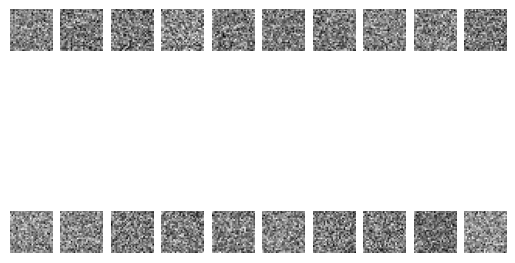

8/8 [==============================] - 0s 2ms/step
100 loss_D 0.433530829846859 loss_G 3.587376117706299


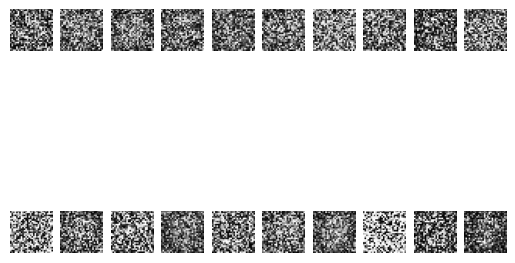

8/8 [==============================] - 0s 2ms/step
200 loss_D 0.7210158407688141 loss_G 0.625532329082489


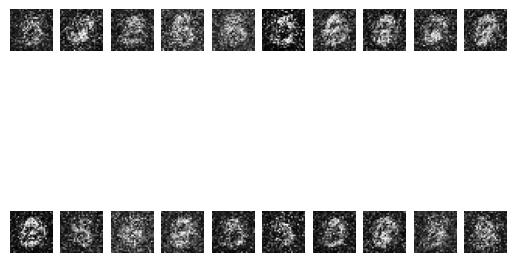

8/8 [==============================] - 0s 2ms/step
300 loss_D 0.662539467215538 loss_G 0.6259703636169434


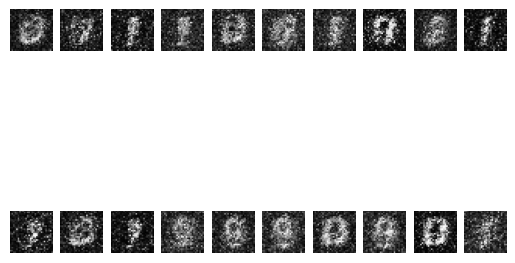

8/8 [==============================] - 0s 2ms/step
400 loss_D 0.6464768052101135 loss_G 0.6837678551673889


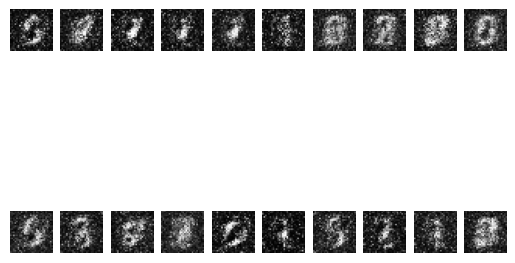

8/8 [==============================] - 0s 4ms/step
500 loss_D 0.6277754008769989 loss_G 0.7311735153198242


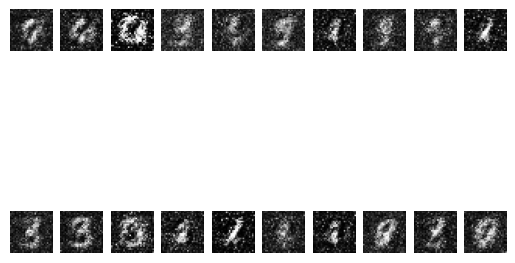

8/8 [==============================] - 0s 2ms/step
600 loss_D 0.6362318396568298 loss_G 0.7634339332580566


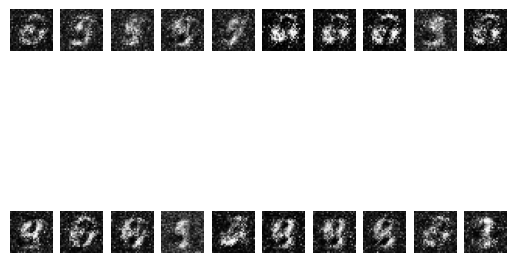

8/8 [==============================] - 0s 3ms/step
700 loss_D 0.6625801920890808 loss_G 0.7542131543159485


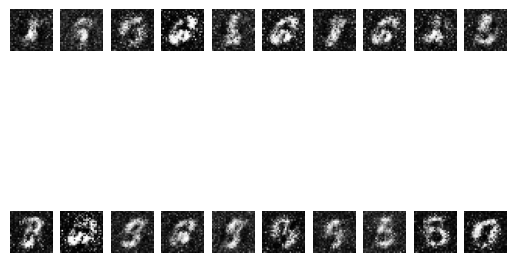

8/8 [==============================] - 0s 3ms/step
800 loss_D 0.6499589681625366 loss_G 0.7438028454780579


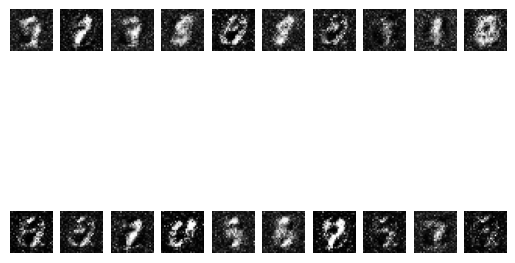

8/8 [==============================] - 0s 3ms/step
900 loss_D 0.6657919883728027 loss_G 0.7585110664367676


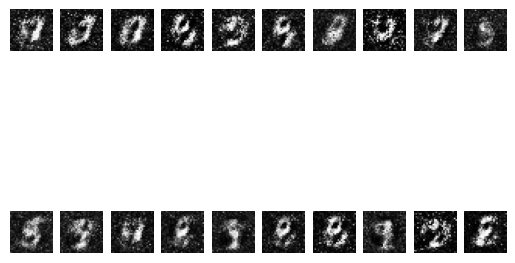

8/8 [==============================] - 0s 3ms/step
1000 loss_D 0.6117664575576782 loss_G 0.8103961944580078


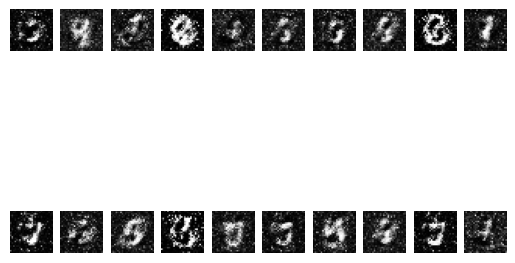

8/8 [==============================] - 0s 3ms/step
1100 loss_D 0.621469110250473 loss_G 0.807575523853302


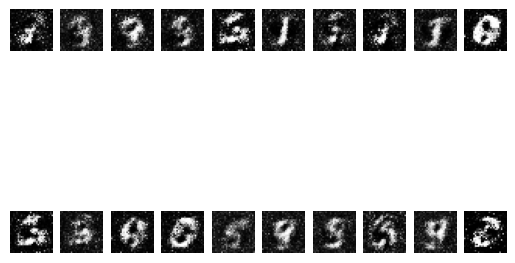

8/8 [==============================] - 0s 3ms/step
1200 loss_D 0.6321739256381989 loss_G 0.8614583015441895


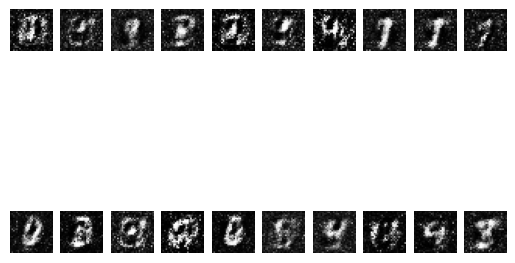

8/8 [==============================] - 0s 2ms/step
1300 loss_D 0.6293894648551941 loss_G 0.8678670525550842


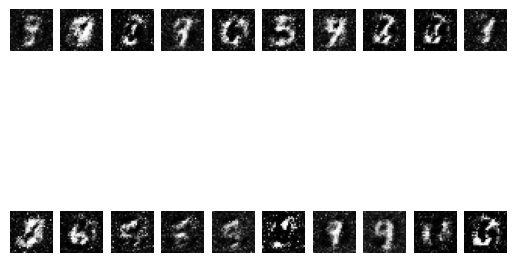

8/8 [==============================] - 0s 3ms/step
1400 loss_D 0.6050882041454315 loss_G 0.9109550714492798


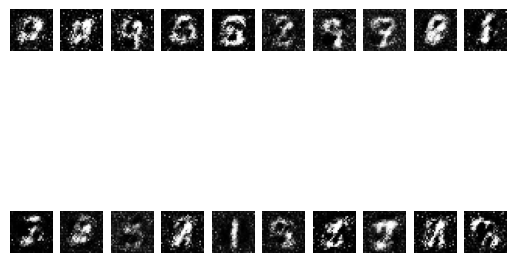

8/8 [==============================] - 0s 3ms/step
1500 loss_D 0.6072849035263062 loss_G 0.8858577609062195


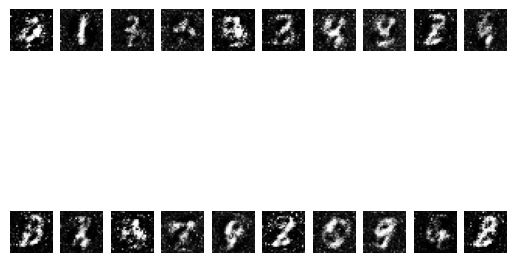

8/8 [==============================] - 0s 3ms/step
1600 loss_D 0.6108593642711639 loss_G 0.9260824918746948


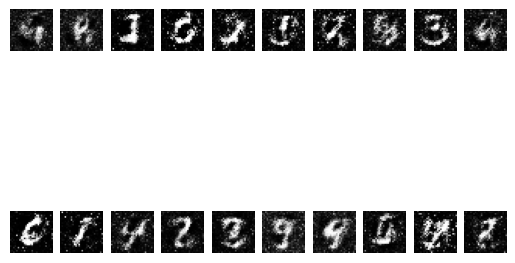

8/8 [==============================] - 0s 3ms/step
1700 loss_D 0.6224124431610107 loss_G 0.8995346426963806


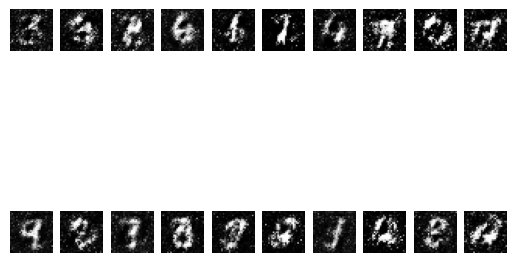

8/8 [==============================] - 0s 3ms/step
1800 loss_D 0.6123625636100769 loss_G 0.899973452091217


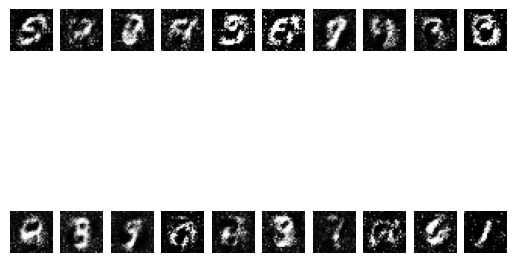

8/8 [==============================] - 0s 3ms/step
1900 loss_D 0.6484626531600952 loss_G 0.8795711994171143


<ipython-input-2-db36b8b4d7e2>:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(r, c)


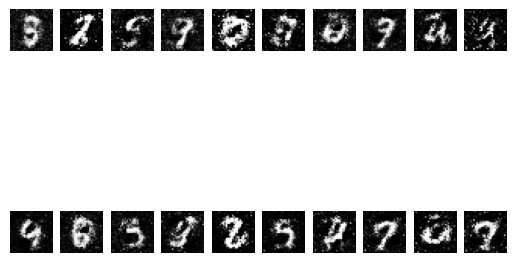

8/8 [==============================] - 0s 3ms/step
2000 loss_D 0.6272269785404205 loss_G 0.9061585664749146


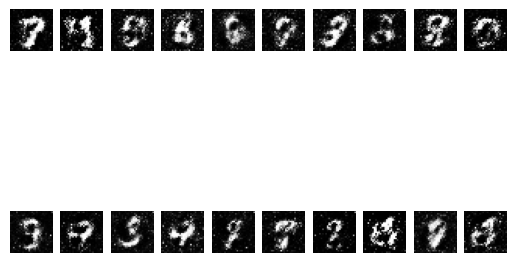

8/8 [==============================] - 0s 3ms/step
2100 loss_D 0.6310628354549408 loss_G 0.8696486353874207


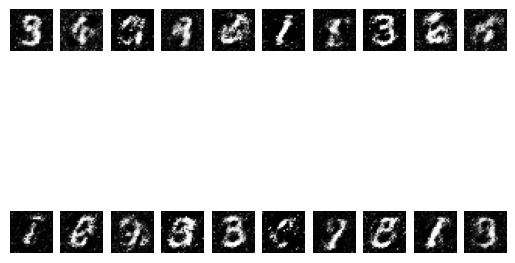

8/8 [==============================] - 0s 3ms/step
2200 loss_D 0.6293034851551056 loss_G 0.8989334106445312


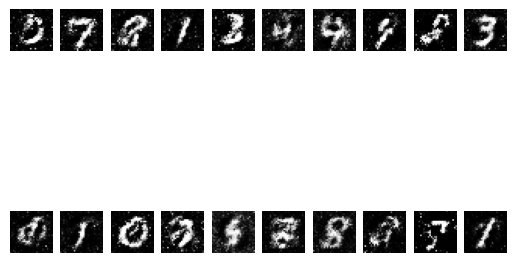

8/8 [==============================] - 0s 3ms/step
2300 loss_D 0.655387818813324 loss_G 0.8784642815589905


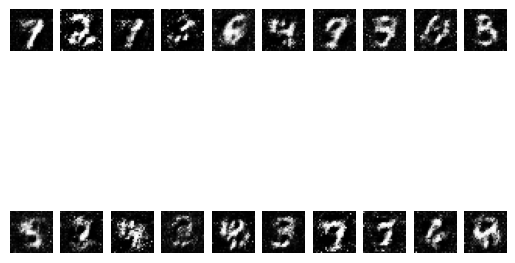

8/8 [==============================] - 0s 3ms/step
2400 loss_D 0.6334450244903564 loss_G 0.9055880308151245


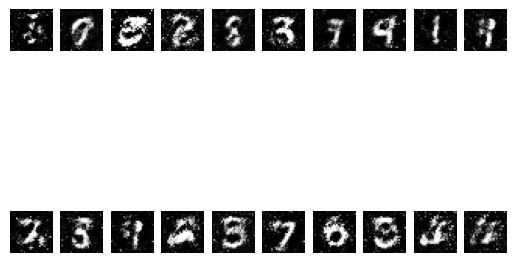

8/8 [==============================] - 0s 3ms/step
2500 loss_D 0.6381034553050995 loss_G 0.8570672869682312


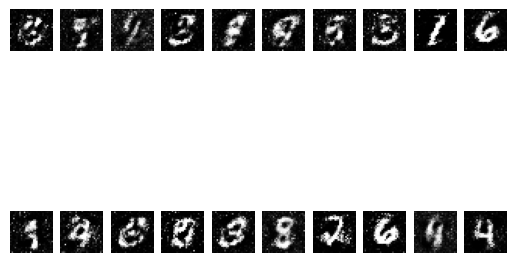

8/8 [==============================] - 0s 3ms/step
2600 loss_D 0.6461665034294128 loss_G 0.8761522769927979


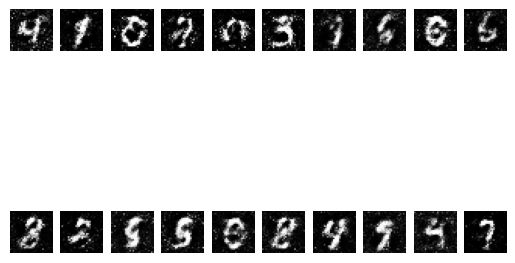

8/8 [==============================] - 0s 2ms/step
2700 loss_D 0.6270124912261963 loss_G 0.8795706629753113


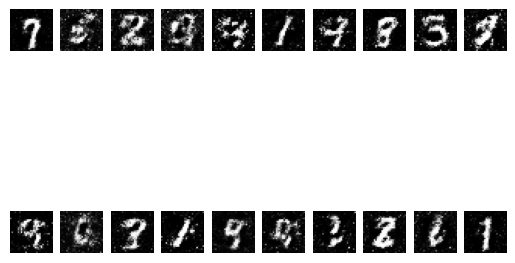

8/8 [==============================] - 0s 3ms/step
2800 loss_D 0.652366042137146 loss_G 0.8572454452514648


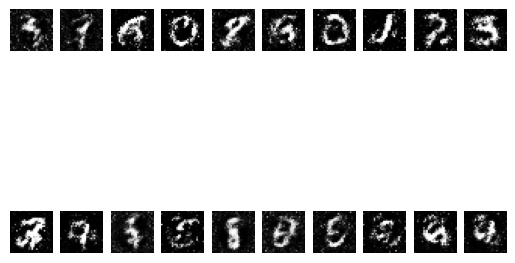

8/8 [==============================] - 0s 3ms/step
2900 loss_D 0.6311141550540924 loss_G 0.8563382625579834


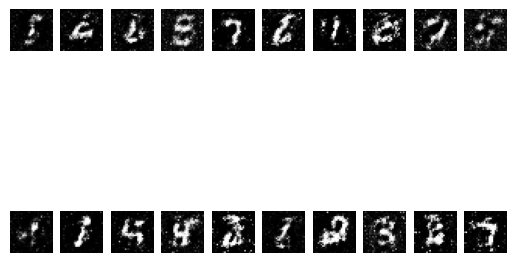

8/8 [==============================] - 0s 3ms/step
3000 loss_D 0.6502620279788971 loss_G 0.8657286763191223


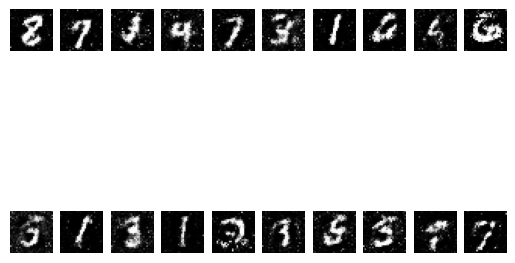

8/8 [==============================] - 0s 3ms/step
3100 loss_D 0.6540015637874603 loss_G 0.8528473973274231


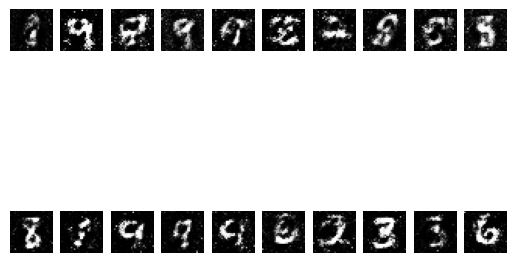

8/8 [==============================] - 0s 3ms/step
3200 loss_D 0.6571435332298279 loss_G 0.8317013382911682


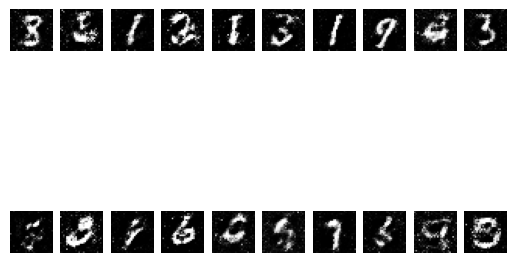

8/8 [==============================] - 0s 3ms/step
3300 loss_D 0.629249632358551 loss_G 0.846693754196167


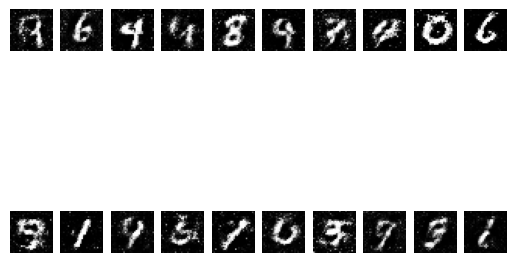

8/8 [==============================] - 0s 3ms/step
3400 loss_D 0.6444502174854279 loss_G 0.836118221282959


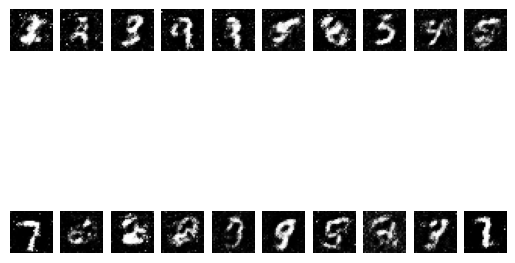

8/8 [==============================] - 0s 3ms/step
3500 loss_D 0.6440629065036774 loss_G 0.8202453851699829


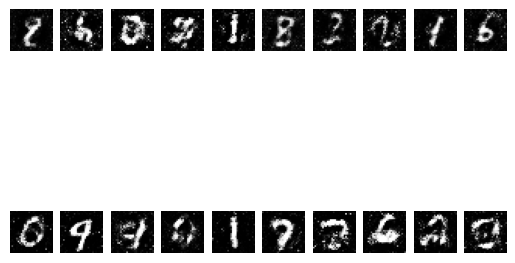

8/8 [==============================] - 0s 4ms/step
3600 loss_D 0.6737227439880371 loss_G 0.8176167607307434


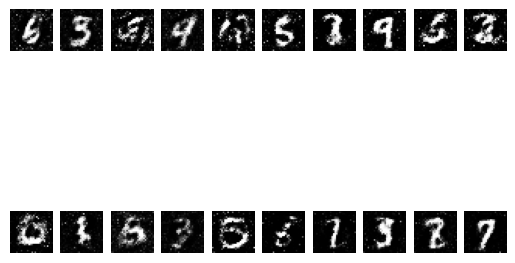

8/8 [==============================] - 0s 3ms/step
3700 loss_D 0.6818162798881531 loss_G 0.8133401870727539


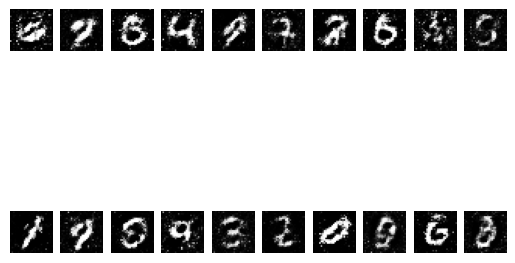

8/8 [==============================] - 0s 3ms/step
3800 loss_D 0.6745055615901947 loss_G 0.8454474806785583


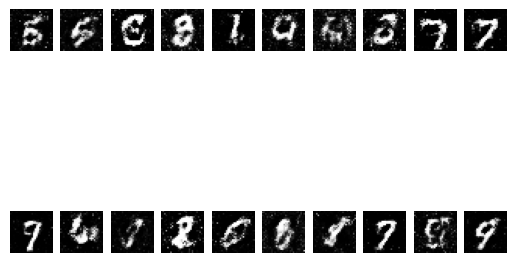

8/8 [==============================] - 0s 3ms/step
3900 loss_D 0.6773708164691925 loss_G 0.8080964088439941


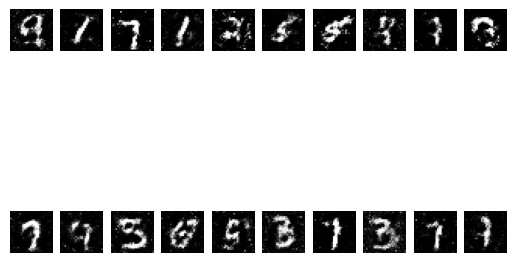

8/8 [==============================] - 0s 3ms/step
4000 loss_D 0.6838860809803009 loss_G 0.8247865438461304


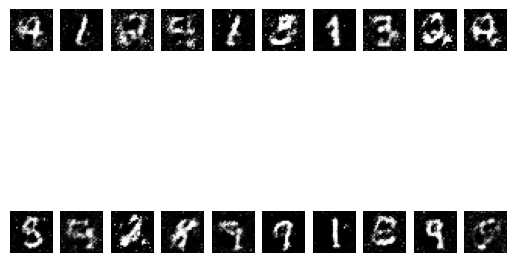

8/8 [==============================] - 0s 5ms/step
4100 loss_D 0.6630541384220123 loss_G 0.8218705058097839


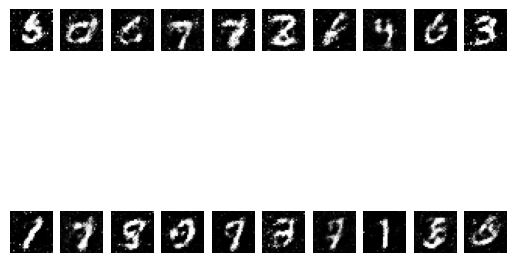

8/8 [==============================] - 0s 3ms/step
4200 loss_D 0.6662284433841705 loss_G 0.8151700496673584


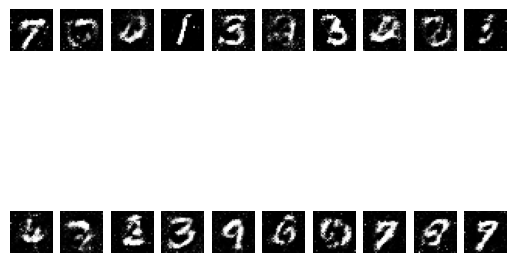

8/8 [==============================] - 0s 2ms/step
4300 loss_D 0.6604257225990295 loss_G 0.8115096092224121


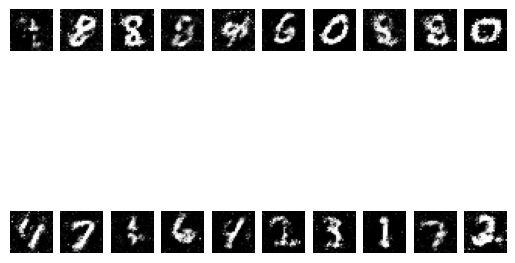

8/8 [==============================] - 0s 6ms/step
4400 loss_D 0.6539318561553955 loss_G 0.8051739931106567


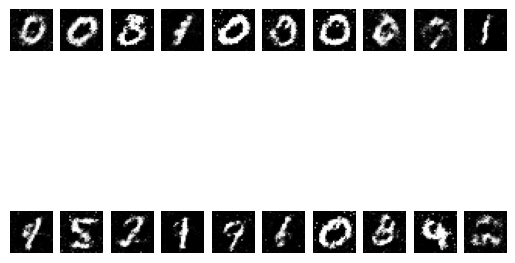

8/8 [==============================] - 0s 3ms/step
4500 loss_D 0.6847193539142609 loss_G 0.7957873344421387


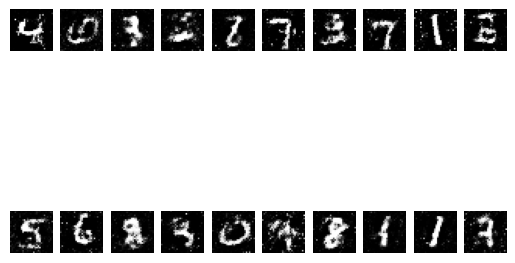

8/8 [==============================] - 0s 3ms/step
4600 loss_D 0.6468113362789154 loss_G 0.8086780309677124


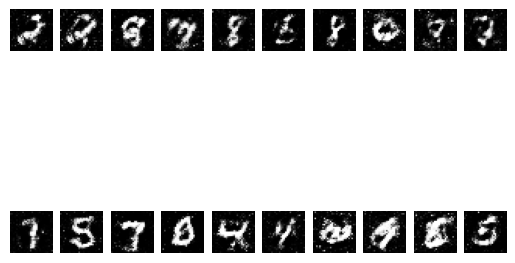

8/8 [==============================] - 0s 3ms/step
4700 loss_D 0.6798277795314789 loss_G 0.8074889779090881


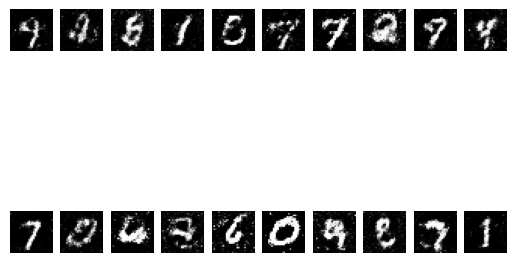

8/8 [==============================] - 0s 3ms/step
4800 loss_D 0.6817596852779388 loss_G 0.7983025312423706


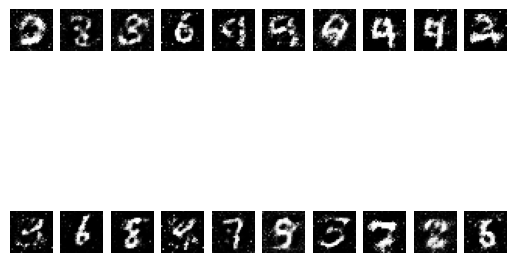

8/8 [==============================] - 0s 3ms/step
4900 loss_D 0.6705660223960876 loss_G 0.8120879530906677


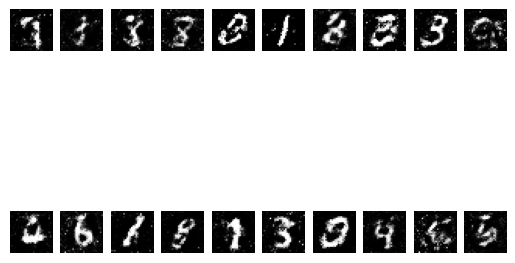

1/1 [==============================] - 0s 18ms/step


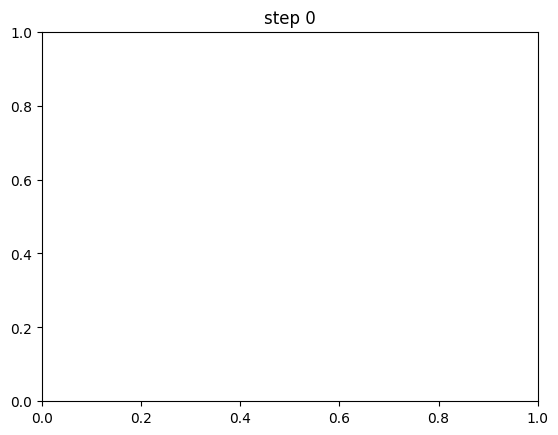

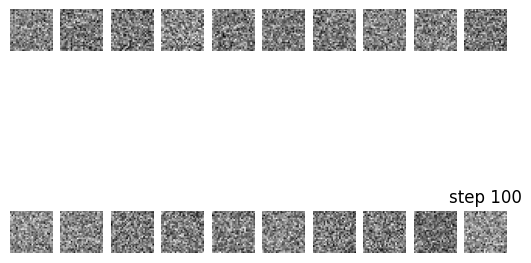

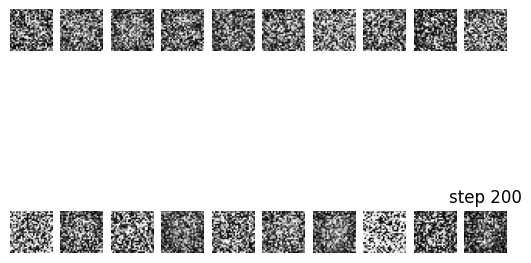

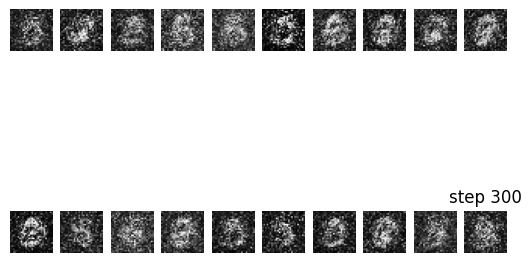

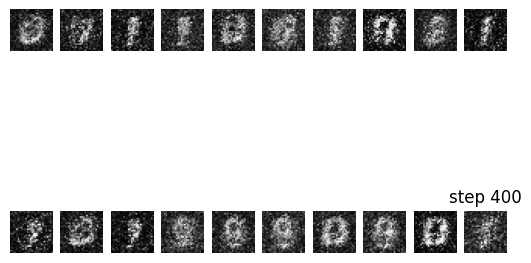

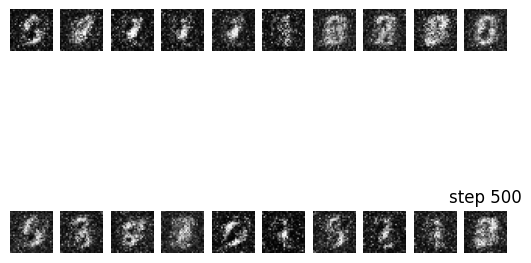

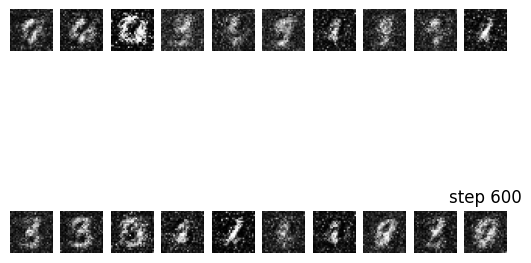

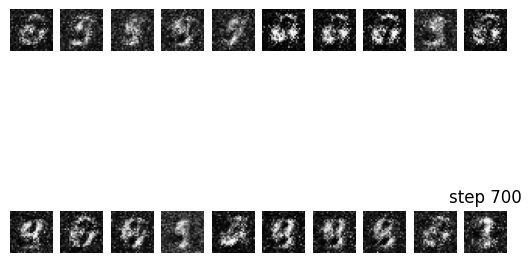

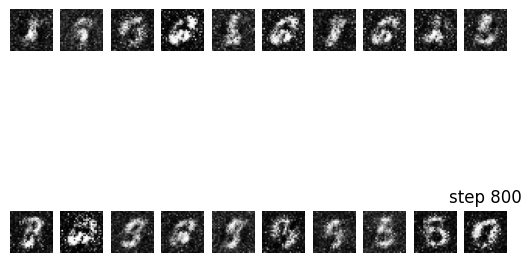

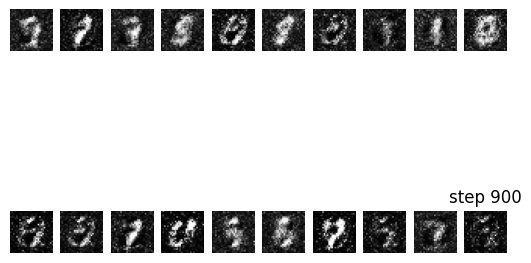

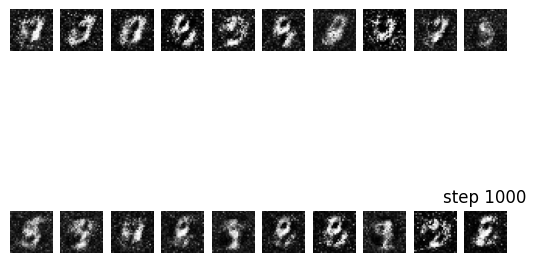

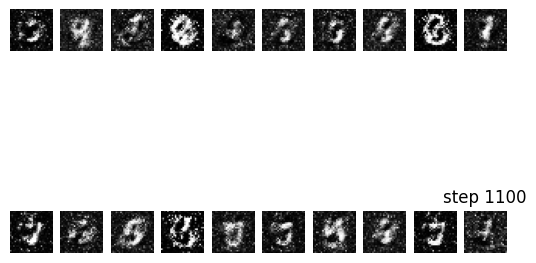

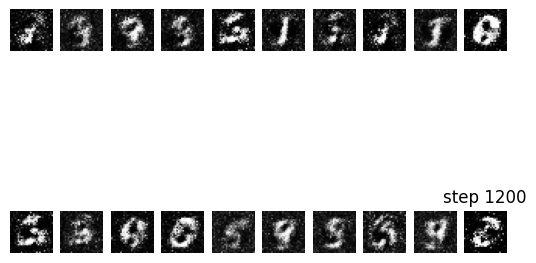

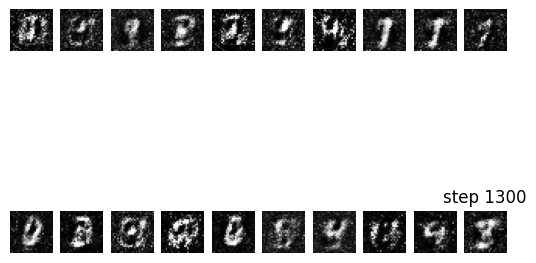

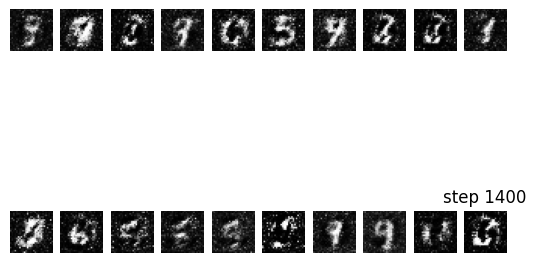

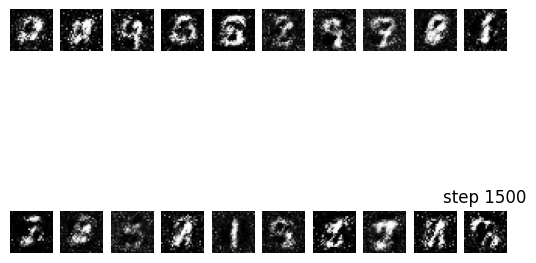

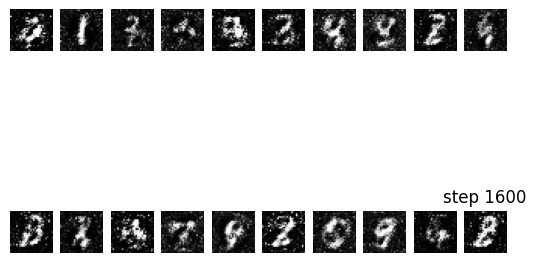

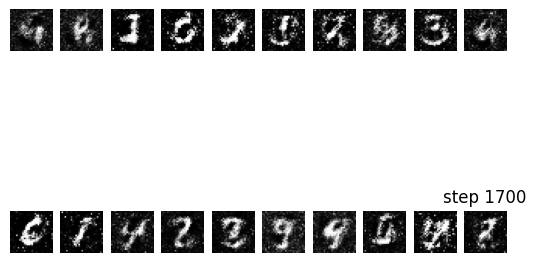

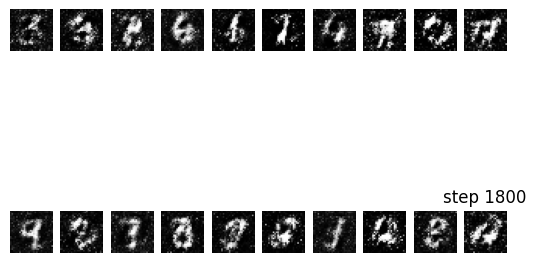

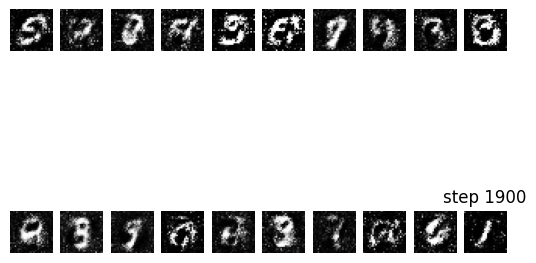

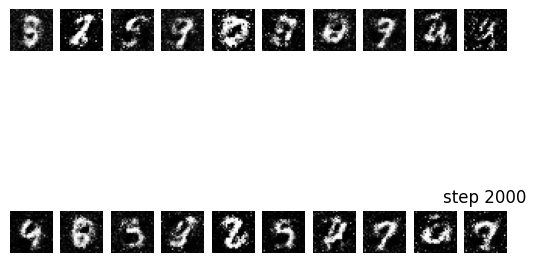

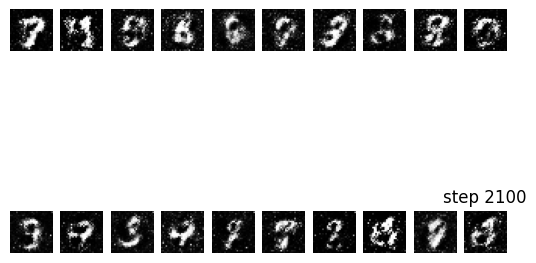

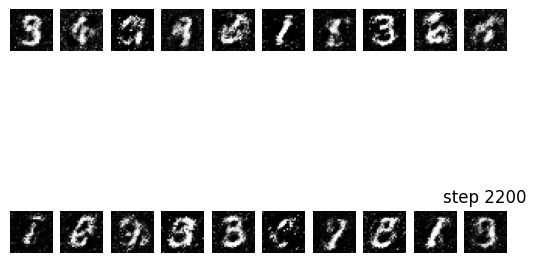

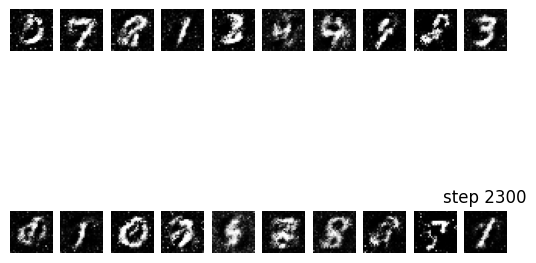

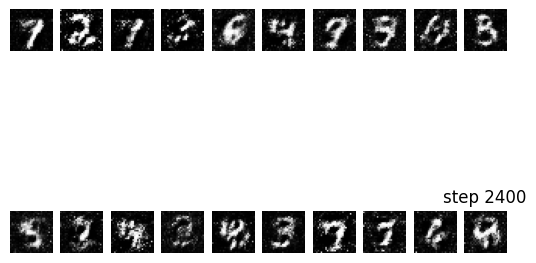

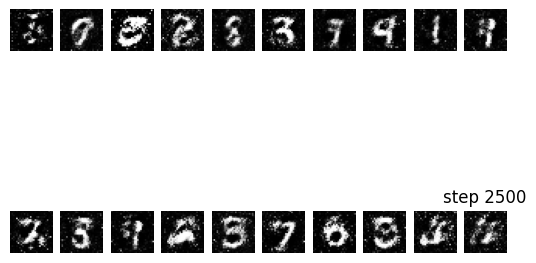

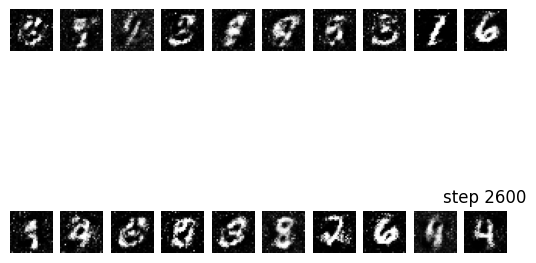

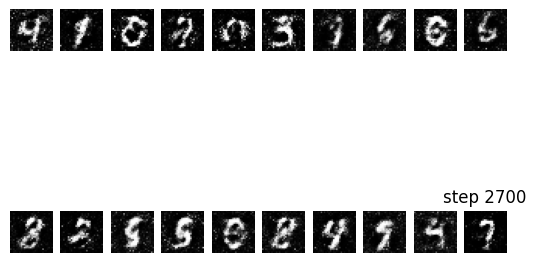

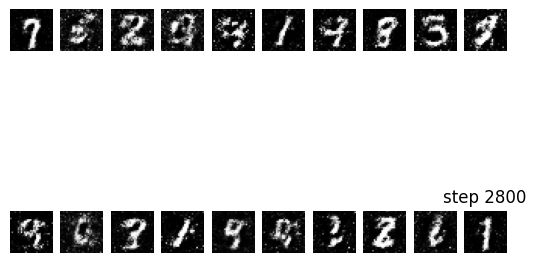

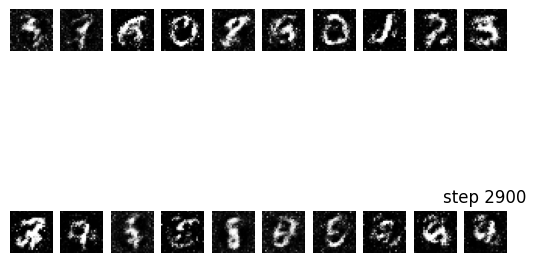

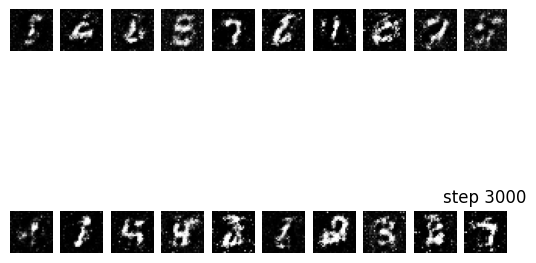

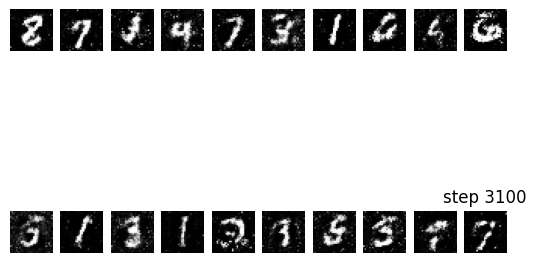

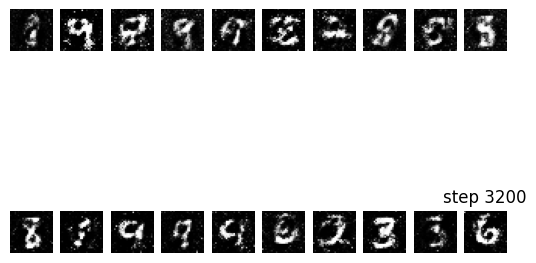

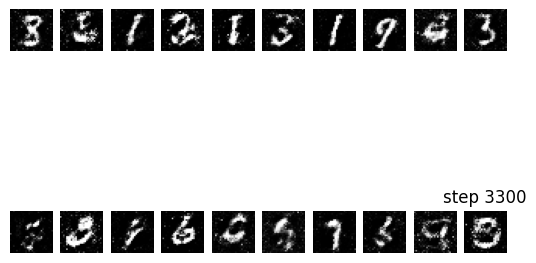

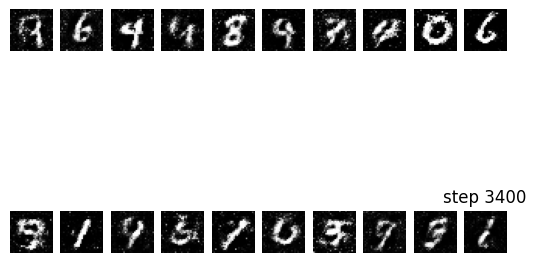

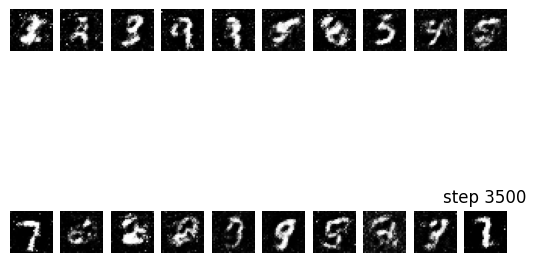

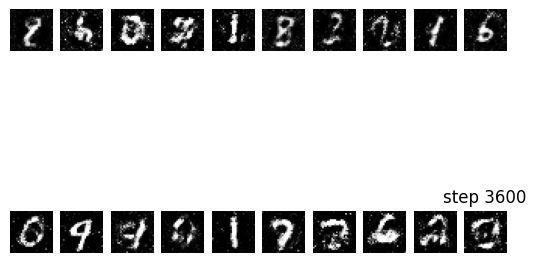

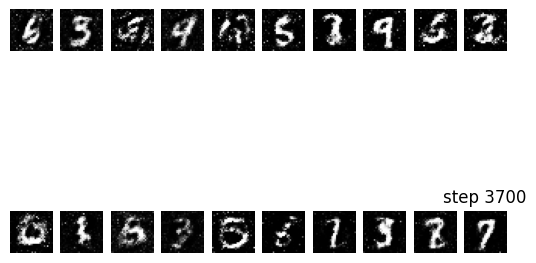

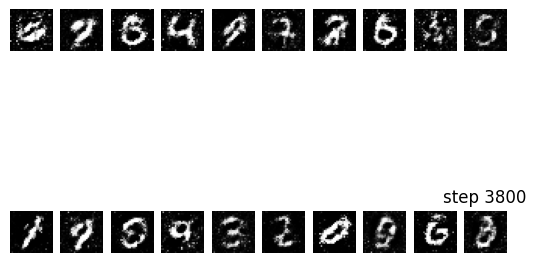

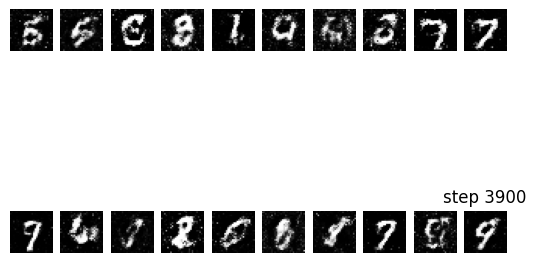

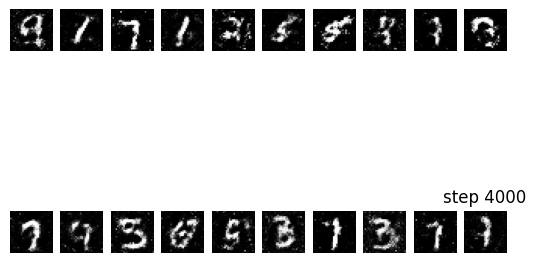

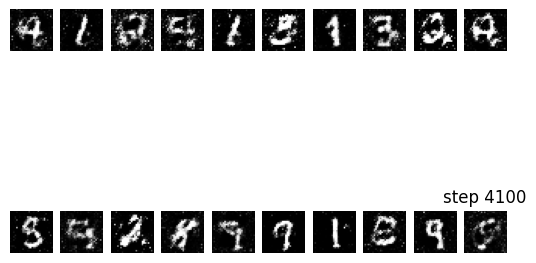

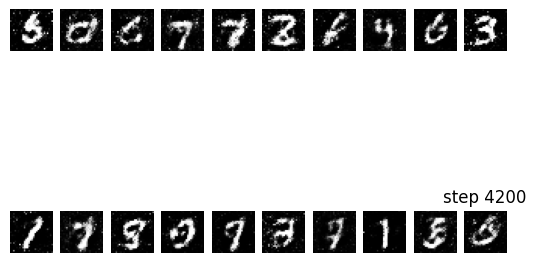

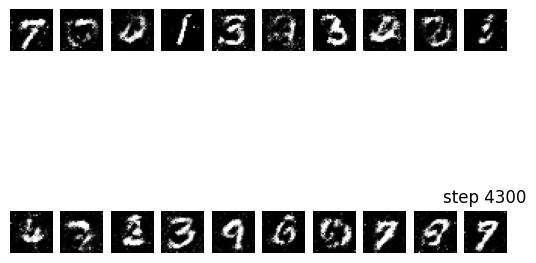

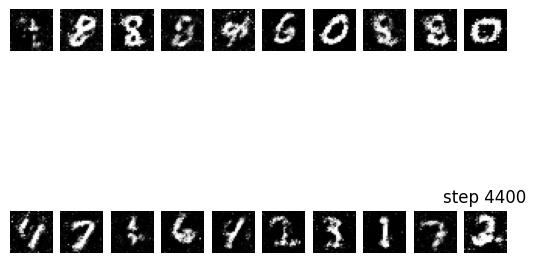

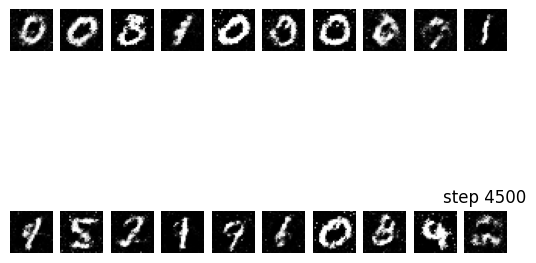

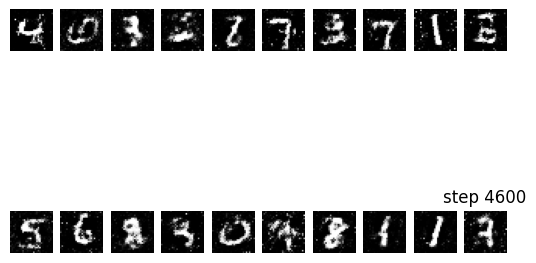

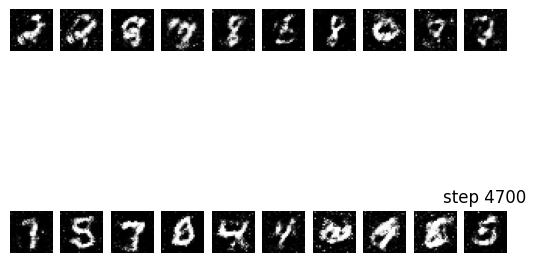

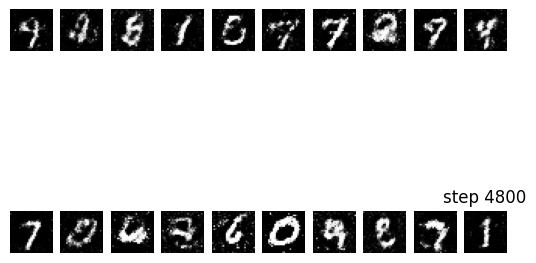

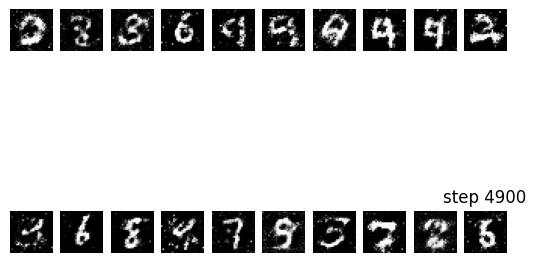

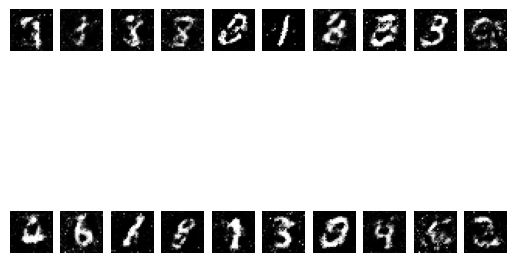

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import numpy as np

class GAN_image():
    """
    This class encapsulates the logic for building and training a Generative Adversarial Network (GAN) for generating images.
    """
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Using the legacy version of Adam optimizer
        optimizer = keras.optimizers.legacy.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

# training parameters
steps = 30000
batch_size = 256

# creating the GAN
gan = GAN_image()

# loading the dataset
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# scaling images
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis=3)  # to have the color channel, that is needed

# defining outputs for discriminator (real and fake)
valid = np.ones((batch_size, 1))  # D(x) = 1
fake = np.zeros((batch_size, 1))  # D(G(z)) = 0

# displaying generated images
from IPython import display
def plot_images(gan, step):
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
    gen_imgs = gan.generator.predict(noise, verbose=0)

    # rescale: 0-1 (from -1 -- 1)
    gen_imgs = 0.5 * gen_imgs + 0.5

    plt.title('step ' + str(step))
    fig, ax = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            ax[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            ax[i, j].axis('off')
            cnt += 1

    display.display(plt.gcf())

# training generator and discriminator
for step in range(5000):
    # select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)  # <TODO> define batch_size number of random indexes
    imgs = x_train[idx]  # <TODO> select these random indexes from x_train

    # generating a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))  # <TODO> create batch_size number of gan.latent_dim dimensional np.random.normal noise samples with 0 mean and 1 variance
    gen_imgs = gan.generator.predict(noise)

    # training the discriminator
    d_loss_real = gan.discriminator.train_on_batch(imgs, valid)  # <TODO> train on real images with "valid" labels (1)
    d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)  # <TODO> train on fake images with "fake" labels (0)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # training the generator
    g_loss = gan.combined.train_on_batch(noise, valid)  # <TODO> train on fake images with "valid" labels (1)

    # printing out the log and plotting the generated images
    if step % 100 == 0:
        print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
        plot_images(gan, step)

# Inference
# Generating a single image can be easily performed.
noise = np.random.normal(0, 1, (1, gan.latent_dim))  # defining noise for the generator for 1 image
gen_img = gan.generator.predict(noise)  # generating image from noise
plt.imshow(gen_img.squeeze(), cmap='gray')  # displaying the generated image
